# <div style="text-align: center"> A Datum Walked into a Bookstore:</div><div style="text-align: center"> Web Scraping, Data Collecting, and More </div>

<img src='Wadge_Library.jpg'>
      
                                    Painted by Justin Wadge (Wadge, 2015)

## Contents:
- [Introduction](#Introduction)
- [Setup Phase](#Setup-Phase)
- [Acquisition Phase](#Acquisition-Phase)
- [Processing Phase](#Processing-Phase)
- [Conclusion](#Conclusion)
- [References](#References:)
- [Kaggle Links](#Kaggle-Links)

# Introduction

<p style="text-align: justify"> In this project, the web scraping pipeline framework is employed to organize the working process (see Image 1). The framework is carried out in three phases: setup, acquisition, and processing. In the setup phase, an objective is defined, which is to predict bestselling books with maximum accuracy and minimal time. The Waterstones website will be used for this task. In the acquisition phase, data will be scraped from the Waterstones website, then parsed and extracted using the web scraping tools Beautiful Soup and Selenium. The purpose is to change the data into a usable format. In the processing phase, data will be processed in two main stages: data understating and data preparation. </p>

<img src='Pipeline_Framework.png'>
           
                 Image 1: Scraping Pipeline Framework (source: edited image from Laetsch, 2020)

# Setup Phase
## Problem Statement
### <p><strong><em> Bestseller or not bestseller — that is the question. </strong>

<div style="text-align: justify"> Every day, vast amounts of data are generated and used, which many industries rely and capitalize on, such as the entertainment, sports, and IT industries. The publishing industry uses data to predict bestsellers, which is not a simple process. Conventionally, predicting bestsellers is done mostly by sharp critics and publishing houses after an extremely long process that is a mix of intuition and informed guesses. Although this process once served the industry well, it is both lengthy and costly, and the predictions are not always accurate. The objective of collecting this data is to predict bestselling books with maximum accuracy based on the provided datasets.</div>

# Acquisition Phase
## Web Scraping
### <p><strong><em> Where the magic happens. </strong>

<div style="text-align: justify"> In this phase, data will be extracted from Waterstones’s online bookstore and transformed into structured data for further analysis. This website was chosen for its high volume of sales and thus provides a lot of insights.</div>

In [2]:
# Installing necessary libraries
from selenium import webdriver
from bs4 import BeautifulSoup 
import time
import pandas as pd
import re
from selenium.webdriver.support.ui import WebDriverWait
import requests

In [3]:
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import matplotlib.pyplot as plt 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from pandas_profiling import ProfileReport

In [ ]:
# Web to be scraped
url = "https://www.waterstones.com/books/bestsellers/sort/bestselling/page/"

In [ ]:
# Accessing and navigating Waterstones website. 
# Then, suspending execution for five seconds in order for pages to load.
# The website's data will be extracted from 100 page and parsed.

data = []
for page in range(1, 100):
    
    driver = webdriver.Chrome('chromedriver/chromedriver')
    driver.get(url + str(page))
    time.sleep(5)
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    with open('scraped_new.txt', 'w') as file:
        file.write(str(soup))
    
    element = driver.find_element_by_xpath("/html/body/div/div[2]/div[3]/div[3]/button")
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    results = soup.find_all("div", {"class": "info-wrap"})

    # The extracted data will be assigned to appropriate features
    for result in results:
        datum = {}
        book_name = result.find("div", {"class": "title-wrap"}).get_text()
        author = result.find("a", {"class": "text-gold"}).get_text()
        availability_status = result.find("span", {"class": "format"}).get_text()
        price = result.find("div", {"class": "book-price"}).get_text()
        original_price = result.find("span", {"class": "price-rrp"})
        current_price = result.find("span", {"class": "price"}).get_text()
        star_rating = result.find("div", {"class": "star-rating"})
        book_status = 'Not Bestseller'

        # Defining functions to clean the extracted data
        def strip_string(var):
            var =str(var)
            var = var.rstrip()
            var = var.replace('\n', '')
            return var
        def strip_price(var):
            if "-" in var:
                return None
            var = var.rstrip()
            var = var.replace('\n', '')
            var = var.replace('$', '')
            var = var.replace(',', '')
            var = float(var)
            return var
        
        # Cleaning extracted data
        datum['book_name'] = strip_string(book_name)
        datum['author'] = strip_string(author)
        datum['availability_status'] =  strip_string(availability_status)     
        s =re.split(r'(\d.\d\\s\\s\\s)',strip_string(price))
        for i in s:
            book_type = i.split()
        datum['book_format']= book_type[-1]
        datum['original_price'] = strip_string(original_price)
        datum['current_price'] = strip_string(current_price)
        
        # Cleaning the'star-rating' feature
        # Books that were not reviewed were assigned 'No Rating' because zero indicates low rating-- 
        # --which is inaccurate, as the books were not reviewed to begin with
        full =([i for i in range(len(strip_string(star_rating))) if strip_string(star_rating).startswith('full', i)])
        half =([i for i in range(len(strip_string(star_rating))) if strip_string(star_rating).startswith('half', i)])
        stars =([i for i in range(len(strip_string(star_rating))) if strip_string(star_rating).startswith('star-icon', i)])
        if len(stars) != 0:
            datum['star_rating'] = (len(full)) + (len(half)*0.5)
        else: datum['star_rating'] = 'No Rating'
        datum['book_status'] = book_status    
        data.append(datum)


## Preprocessing
In this section, raw data is being processed for other processing procedure.

In [ ]:
# Creating a DataFrame
books_df = pd.DataFrame(data, columns = ['book_name','author','availability_status','original_price','current_price','star_rating','book_status'])

In [ ]:
# Saving raw data 
books_df.to_csv('Bestseller_Booklist_raw.csv')

In [5]:
# Removing values without authors as they are unrelated items (not books)
books_df = books_df[books_df.author !='']

In [6]:
# Reseting index after dropping unrelated items to sort the index
books_df.reset_index(inplace = True, drop = True)

In [7]:
# Assigning top 20% bestselling books the bestseller status
books_df.head(400)['book_status'] = 'Bestseller'

/Users/Maram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [8]:
#Checking the length
len(books_df)

2376

In [9]:
#Checking the data
books_df.tail(20)

book_name                    author availability_status  \
2356   Three Years in Hell            Fintan O'Toole     In stock online   
2357       The Very Short…              John Gillard     In stock online   
2358        Chronicles of…            Michelle Paver     In stock online   
2359          London Rules               Mick Herron     In stock online   
2360     Agent Weasel and…                 Nick East     In stock online   
2361       The Metabolism…      Dr Alan Christianson     In stock online   
2362         Waboba Street                       NaN     In stock online   
2363     Pearl of Pit Lane              Glenda Young     In stock online   
2364        Absolute Proof               Peter James     In stock online   
2365    Oxford Children's…       Oxford Dictionaries     In stock online   
2366   The Telegraph: All…             The Telegraph     In stock online   
2367  Started Early, Took…             Kate Atkinson     In stock online   
2368         Harry Potter…                       NaN     In stock online   
2369    The Girl With All…               M. R. Carey     In stock online   
2370     Fantastic Mr Fox…                Roald Dahl     In stock online   
2371       The Wild Places         Robert Macfarlane     In stock online   
2372   Garden Birds Cloth…                       NaN     In stock online   
2373       Purple Hibiscus  Chimamanda Ngozi Adichie     In stock online   
2374     10 Minutes A Day…           Carol Vorderman     In stock online   
2375  A Daughter's Journey               Anna Jacobs     In stock online   

                             original_price current_price star_rating  \
2356  <span class="price-rrp">£20.00</span>        £16.99   No Rating   
2357                                   None        £14.99   No Rating   
2358                                   None         £7.99         4.5   
2359                                   None         £8.99         5.0   
2360   <span class="price-rrp">£6.99</span>         £4.99         5.0   
2361                                   None        £14.99   No Rating   
2362                                   None         £5.99   No Rating   
2363                                   None         £6.99   No Rating   
2364                                   None         £8.99         3.5   
2365                                   None        £10.99   No Rating   
2366                                   None         £6.99   No Rating   
2367                                   None         £8.99         4.5   
2368                                   None         £3.99   No Rating   
2369                                   None         £8.99         4.5   
2370                                   None         £7.99         4.5   
2371                                   None         £9.99   No Rating   
2372                                   None        £16.99   No Rating   
2373                                   None         £8.99         4.5   
2374                                   None         £5.99   No Rating   
2375                                   None         £6.99   No Rating   

         book_status  
2356  Not Bestseller  
2357  Not Bestseller  
2358  Not Bestseller  
2359  Not Bestseller  
2360  Not Bestseller  
2361  Not Bestseller  
2362  Not Bestseller  
2363  Not Bestseller  
2364  Not Bestseller  
2365  Not Bestseller  
2366  Not Bestseller  
2367  Not Bestseller  
2368  Not Bestseller  
2369  Not Bestseller  
2370  Not Bestseller  
2371  Not Bestseller  
2372  Not Bestseller  
2373  Not Bestseller  
2374  Not Bestseller  
2375  Not Bestseller

In [10]:
# Defining a function to clean tags
def cleanTags(text):
    clean = re.compile('<.*?>')
    data =[]
    for i in text:
        data.append(re.sub(clean,'',i))
    return data

In [11]:
books_df['original_price'] = cleanTags(books_df['original_price'])

In [12]:
# Defining a function to remove pound sign
def cleanPound(prices):
    clean = re.compile('.*?£')
    data =[]
    for i in prices:
        data.append(re.sub(clean,'',i))
    return data

books_df['original_price'] = cleanPound(books_df['original_price'])
books_df['current_price'] = cleanPound(books_df['current_price'])

In [13]:
# Randomly shuffling the dataset to not have the 'Bestseller' column ordered. 
books_df.sample(frac = 1)

book_name                   author  availability_status  \
284           Wolf Hall            Hilary Mantel      In stock online   
1445      King of Scars            Leigh Bardugo      In stock online   
1848       Without Fail                Lee Child      In stock online   
1557   5 Ingredients -…             Jamie Oliver      In stock online   
224            Tombland             C. J. Sansom      In stock online   
...                 ...                      ...                  ...   
1471  Crazy Rich Asians               Kevin Kwan      In stock online   
720             Calypso            David Sedaris      In stock online   
2284   Maths Made Easy…          Carol Vorderman  Available in 1 week   
1814  You Can't Let an…  Patricia Cleveland-Peck      In stock online   
1976                Gbh                Ted Lewis      In stock online   

     original_price current_price star_rating     book_status  
284            None          9.99         4.5      Bestseller  
1445           8.99          6.99         4.5  Not Bestseller  
1848           None          8.99         4.5  Not Bestseller  
1557           None         26.00         4.5  Not Bestseller  
224            8.99          7.49         5.0      Bestseller  
...             ...           ...         ...             ...  
1471           None          7.99         5.0  Not Bestseller  
720            None          9.99   No Rating  Not Bestseller  
2284           None          3.99   No Rating  Not Bestseller  
1814           None          6.99   No Rating  Not Bestseller  
1976           None          9.99   No Rating  Not Bestseller  

[2376 rows x 7 columns]

In [14]:
# Dropping the index
books_df.reset_index(drop = True)

book_name                    author availability_status  \
0        The Mirror & the…             Hilary Mantel     In stock online   
1       Girl, Woman, Other       Bernardine Evaristo     In stock online   
2          Invisible Women     Caroline Criado-Perez     In stock online   
3       The Boy, the Mole…           Charlie Mackesy     In stock online   
4                The Chain            Adrian McKinty     In stock online   
...                    ...                       ...                 ...   
2371       The Wild Places         Robert Macfarlane     In stock online   
2372   Garden Birds Cloth…                       NaN     In stock online   
2373       Purple Hibiscus  Chimamanda Ngozi Adichie     In stock online   
2374     10 Minutes A Day…           Carol Vorderman     In stock online   
2375  A Daughter's Journey               Anna Jacobs     In stock online   

     original_price current_price star_rating     book_status  
0             25.00         18.00         5.0      Bestseller  
1              8.99          6.99         4.5      Bestseller  
2              9.99          7.99         5.0      Bestseller  
3             16.99         14.99         5.0      Bestseller  
4              8.99          6.99         4.5      Bestseller  
...             ...           ...         ...             ...  
2371           None          9.99   No Rating  Not Bestseller  
2372           None         16.99   No Rating  Not Bestseller  
2373           None          8.99         4.5  Not Bestseller  
2374           None          5.99   No Rating  Not Bestseller  
2375           None          6.99   No Rating  Not Bestseller  

[2376 rows x 7 columns]

In [15]:
books_df.to_csv('Bestseller_Booklist.csv')

# Processing Phase
## Data Understanding
### <p><strong><em> To err is machine, to clean is divine.</strong>

<div style="text-align: justify"> In this phase, there are three main stages: data understating, where the data will be examined for its quality, quantity, and usefulness, among other things; data preparation, which is concerned with cleaning and preparing data for analysis; and data analysis, when data will be analyzed and visualized.</div>

## Dataset Description
The books dataset contains information about the listed books.

### Variable Description
- **book_name**: refers to the name of the book
- **author**: refers to the name of the author
- **availability_status**: refers to the status of the book: in stock, in stock online, available in 1 week, pre-order, cancelled, or click and collect only
- **original_price**: refers to the price of the book
- **current_price**: refers to the current price of the book
- **star_rating**: refers to customer submitted reviews
- **book_status**: refers to the book’s selling status: either a bestseller or not

In [16]:
# Checking rows and columns
books_df.shape

(2376, 7)

In [17]:
# Checking data description
books_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2376 entries, 0 to 2375
Data columns (total 7 columns):
book_name              2376 non-null object
author                 2046 non-null object
availability_status    2365 non-null object
original_price         2376 non-null object
current_price          2376 non-null object
star_rating            2376 non-null object
book_status            2376 non-null object
dtypes: object(7)
memory usage: 130.1+ KB


In [18]:
# Checking data description
books_df.describe()

book_name           author availability_status original_price  \
count                2376             2046                2365           2376   
unique               2105             1232                   5             19   
top     Diary of a Wimpy…  Julia Donaldson     In stock online           None   
freq                   13               45                2325           1717   

       current_price star_rating     book_status  
count           2376        2376            2376  
unique            74          11               2  
top             6.99   No Rating  Not Bestseller  
freq             401         849            1976

In [19]:
# Checking maximum possible value of features
# This is only useful for features with numeric values
books_df.max()

book_name         wagamama Feed…
original_price              None
current_price               9.99
star_rating            No Rating
book_status       Not Bestseller
dtype: object

In [20]:
# Checking minimum possible value of features
# This is only useful for features with numeric values
books_df.min()

book_name         'Salem's Lot
original_price           10.99
current_price             1.00
star_rating                0.0
book_status         Bestseller
dtype: object

In [21]:
# Displaying feature types
books_df.dtypes

book_name              object
author                 object
availability_status    object
original_price         object
current_price          object
star_rating            object
book_status            object
dtype: object

### Missing Values

In [22]:
# Percentile of the missing data
# No missing data
print("Missing Data")
books_data = books_df.isna().sum()*100 / len(books_df)
print("column name            NA")
print(books_data)

Missing Data
column name            NA
book_name               0.000000
author                 13.888889
availability_status     0.462963
original_price          0.000000
current_price           0.000000
star_rating             0.000000
book_status             0.000000
dtype: float64


## Data Visualization

#### Profile Report:
The following code is used to generate a report for each feature displaying the following: type inference, quantile statistics, descriptive statistics, deviation, most frequent values, histogram, correlations, missing values matrix, and more.

In [23]:
profile_report = ProfileReport(books_df, title='Profile Report', html={'style':{'full_width':True}})
profile_report.to_notebook_iframe()

#### Word Cloud:
The following code is used to display the word cloud graph to represent text data, where the size of each word indicates its frequency.

In [24]:
text = " ".join(title for title in books_df.book_name)

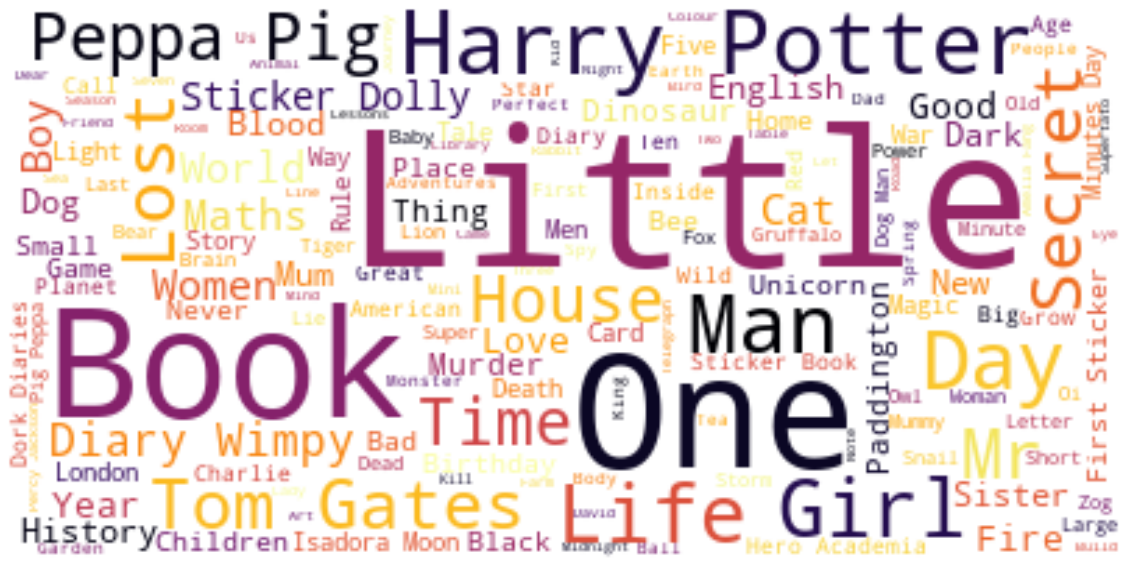

In [25]:
# Displaying the most frequently used words in book names across the entire e dataset
# The bigger the font, the more frequent the word would appear among all books
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=70, max_words=2046, background_color="white", stopwords = stopwords, colormap = 'inferno').generate(text)
plt.figure(figsize = [20, 16])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()  

In [26]:
titles = books_df[books_df.book_status == 'Bestseller']['book_name']

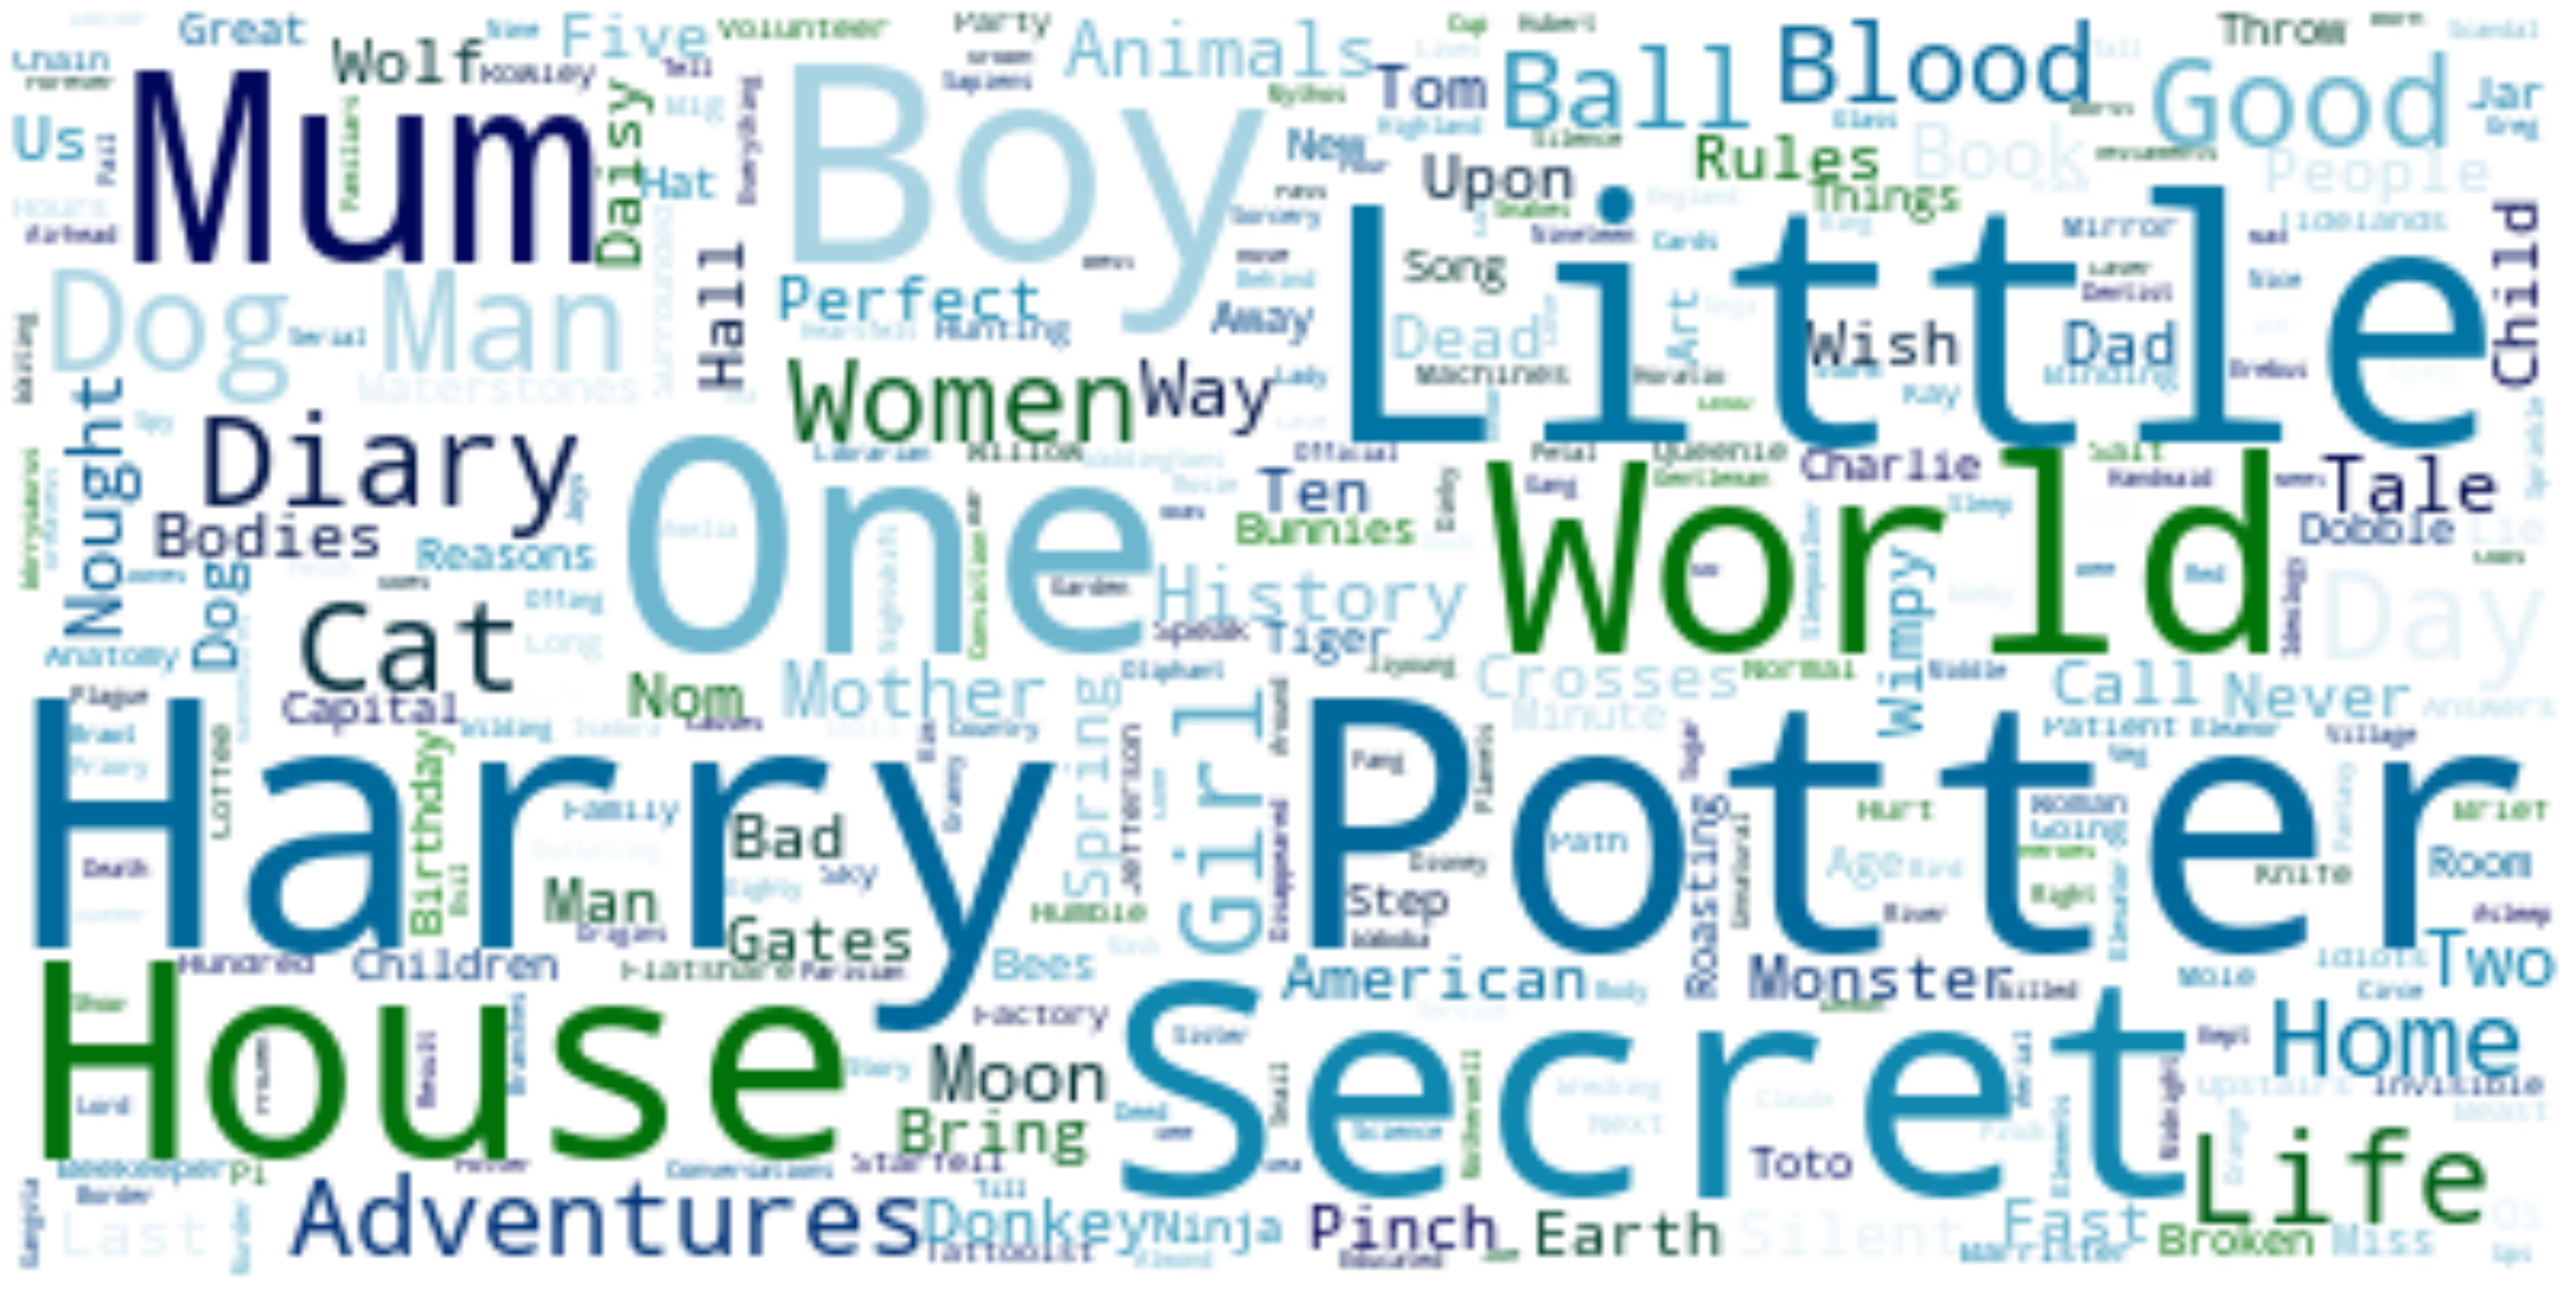

In [33]:
# Displaying the most frequently used words in book names among just bestseller books
# The bigger the font, the more frequent the word would appear among bestseller books
text = " ".join(title for title in titles)
stopwords = set(STOPWORDS)
wordcloud = WordCloud(max_font_size=70, max_words=500, background_color="white", stopwords = stopwords, colormap = 'ocean').generate(text)
plt.figure(figsize = [50, 30])
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()  

## Data Preparation
In this section, the data is being split into train and test datasets to prepare it for Kaggle submission.

### Spliting the data 

In [28]:
# Saving the cleaned data into a csv file
books_df.to_csv('Bestseller_Booklist.csv')

In [29]:
# Spliting the dataframe into train and text datasets.
train = books_df.iloc[0:1432, :]
test = books_df.iloc[1432:, :]

In [30]:
# Saving the 'books_status' feature
target = test['book_status']

In [31]:
# Droping the'books_status' from the test dataset
test.drop(columns = ['book_status'], inplace = True)

/Users/Maram/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [32]:
# Saving the datasets into csv files
train.to_csv('Train.csv')
test.to_csv('Test.csv')
target.to_csv('Target.csv')

/Users/Maram/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


# Conclusion

<div style="text-align: justify"> Web scraping is a crucial skill to acquire in today’s data driven world. Collecting large datasets is fundamental to big data analytics, artificial intelligence, and machine learning. With the explosion of online information, data is becoming much easier to access than ever before using web scraping tools and skills. </div>

## References:

- <p style='text-align: justify;'> Laetsch, T., 2020. Web Scraping With Python, accessed on 19 Mar, 2020:(https://campus.datacamp.com/courses/web-scraping-with-python/introduction-to-html?ex=1).</p>


- <p style='text-align: justify;'> Wadge, J., 2015. Eidlitz: Baroque Libraries, accessed on 19 Mar, 2020:(https://www.justinwadge.com/Architecture/Eidlitz-Baroque-Libraries).</p>

###  Kaggle Links
- Dataset: https://www.kaggle.com/maramedrees/a-datum-walked-into-a-bookstore
- Kernal: https://www.kaggle.com/maramedrees/a-datum-walked-into-a-bookstore-starter-code?scriptVersionId=30473876


 - <a href="https://www.kaggle.com/maramedrees/a-datum-walked-into-a-bookstore-starter-code?scriptVersionId=30473876" target="_blank">Kernal</a>